<a href="https://colab.research.google.com/github/EmmanuelADAM/IntelligenceArtificiellePython/blob/master/GymTaxiDoubleQLearningTODO.ipynb" target="_parent">Ouvrir sous colab</a>


# Machine Learning

## Appliqué à [Gym.OpenAI](https://gym.openai.com)


---

## Test de ML par Q-Learning pour atteindre des objectifs

**Utilisation de l'environnement gymnasium**
(voir la page d'introduction à [gymnasium](https://www.gymlibrary.dev/)).


#### Si besoin, importer gym


In [42]:
#!pip install gymnasium 

---

#### L'environnement Taxi


In [43]:
import gymnasium as gym

---

- Utiliser l'environnement `Taxi-v3`

  - le taxi peut se trouver sur une grille 5x5
  - le passager peut se trouver : dans le taxi, ou dans un des 4 points B(3),G(1),R(0),Y(2).
  - il y a en tout $500$ états possibles : $25\times 5 \times 4$
  - chaque état est representé par un ensemble: (rangee_taxi, colonne_taxi, position_passager, destination_passager)

- les actions sont :

  - 0: sud, 1: nord, 2: est, 3: ouest, 4: prendre un passager, 5: déposer un passager

- les récompenses sont :

  - dépôt d'un passager à destination : +20 points
  - action prise en charge incongrue d'un passager : -10 points
  - dans les autres cas, chaque état coûte 1 point

- Chaque action coûte 1 point, l'arrivée n'en rapporte pas.


---

#### Etude de l'environnement


In [44]:
env = gym.make('Taxi-v3', render_mode='ansi') 
print("specification de l'environnement : ", env.spec)
print("espace d'actions : ", env.action_space ) #ici 4 actions discrétisée
print("espace d'etats : ", env.observation_space) #ici 48 cellules possibles
actions = { 0:'sud', 1:'nord', 2:'est', 3:'ouest', 4:'prendre un passager', 5: 'déposer un passager'}
lieux = {0:'R', 1:'G', 2:'Y', 3:'B'}

s = env.reset()
print(env.render())

print("********l'etat initial change à chaque reset***** ici s= ",s)
x,y,passager_start, passager_end  = env.decode(s[0])
print(f"--> cela correspond à un taxi en ({x},{y}), un passager partant de {lieux[passager_start]} pour {lieux[passager_end]}")

print("Prendre une action au hasard.. ")
a = env.action_space.sample()
print("action choisie=",actions[a],"; l'exécuter...")
#on recupère des valeurs en retour
new_s, reward, done, truncated, info = env.step(a)
print(f"nouvel état={new_s}, recompense sur cet etat={reward}, etat final (but)={done}, etat feuille={truncated}, info={info}")
#note sous python 3.10, la version de gym retourne 5 valeurs : 
#new_s, reward, done, goal, info = env.step(a)
#print(f"nouvel état={new_s}, recompense sur cet etat={reward}, etat final (but)={done},etat but={goal}, info={info}")

print(env.render())


specification de l'environnement :  EnvSpec(id='Taxi-v3', entry_point='gymnasium.envs.toy_text.taxi:TaxiEnv', reward_threshold=8, nondeterministic=False, max_episode_steps=200, order_enforce=True, autoreset=False, disable_env_checker=False, apply_api_compatibility=False, kwargs={'render_mode': 'ansi'}, namespace=None, name='Taxi', version=3, additional_wrappers=(), vector_entry_point=None)
espace d'actions :  Discrete(6)
espace d'etats :  Discrete(500)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+


********l'etat initial change à chaque reset***** ici s=  (142, {'prob': 1.0, 'action_mask': array([1, 1, 1, 0, 0, 0], dtype=int8)})
--> cela correspond à un taxi en (1,2), un passager partant de R pour Y
Prendre une action au hasard.. 
action choisie= sud ; l'exécuter...
nouvel état=242, recompense sur cet etat=-1, etat final (but)=False, etat feuille=False, info={'prob': 1.0, 'action_mask': array([1, 1, 1, 1, 0, 0], dtype=int8)}
+---------+
|R: | : :G

---

#### Test des actions

Sous Gym, `step` permet d'effectuer une action.
En retour la fonction retourne une observation sur l'etat d'arrivee, sa recompense, son type (final ou non), et des informations.

Avec la librairie gym installé sous python 3.9, step retourne :

- observation = position où se trouve l'agent,
- reward = recompense,
- done = vrai si état final atteint,
- info = probabilité de succès de l'action.

Avec la librairie gym installé sous python 3.10, step retourne :

- observation = position où se trouve l'agent,
- reward = recompense,
- done = vrai si état final atteint,
- goal = vrai si but atteint,
- info = probabilité de succès de l'action.


---

### <font color="red">Résolution</font>


---

## Exemple d'algorithme


In [45]:
import numpy as np
import random as rnd

env = gym.make('Taxi-v3', render_mode='ansi') 
actions = { 0:'sud', 1:'nord', 2:'est', 3:'ouest', 4:'prendre un passager', 5: 'déposer un passager'}
lieux = {0:'R', 1:'G', 2:'Y', 3:'B'}


In [46]:
# initialiser la Q-Table
# autant de cases que l'environnement en possède, 
# contenant autant de valeurs que d'actions possibles
# donc ici une matrice 500 x 4
QA = np.zeros([env.observation_space.n,env.action_space.n])
QB = np.zeros([env.observation_space.n,env.action_space.n])

### Mise en place des paramètres

Pour rappel avec l'algo de Double Q Learning, on réalise, plus ou moins alternativement :

- $a^* \gets  argmax_{a} QA(s', a)$,
- $Q_A(s,a) \gets Q_A(s,a) + \lambda \times (r + \gamma \times Q_B(s', a^*))-  Q_A(s,a))$ <br>
  ou<br>
- $b^* \gets  argmax_{a} Q_B(s', a)$
- $Q_B(s,a) \gets Q_B(s,a) + \lambda \times (r + \gamma \times QA(s', b^*))-  Q_B(s,a))$<br>
  avec - $\lambda$ : coef d'apprentissage - $\gamma$ : coef de réduction - $r$ : récompense

Cette équation note la qualité de l'action _a_ à partir de l'état _s_ alternativement dans les tables $Q_A$ et $Q_B$.

Initialement, les actions sont choisies aléatoirement et notées; puis au fil des tests les actions les plus valuées sont choisies. Pour cela, un tirage est effectuée, s'il est inférieur à un $\epsilon$, le choix est aléatoire. Cet $\epsilon$ décroit au fil des tests.


In [47]:
lambda_learn = .2
gamma = 0.99
epsilon = 1.

#### Récupérer la meilleure action

`argmax(tab)` retourne l'indice de la plus grande valeur du tableau.

`argmax(Q[2])` retourne donc le no de l'action la plus intéressante à partir de l'état 2.


## Algorithme Q-Learning simple


In [48]:
from tqdm import tqdm

In [49]:
env = gym.make('Taxi-v3', render_mode='ansi') 
actions = { 0:'sud', 1:'nord', 2:'est', 3:'ouest', 4:'prendre un passager', 5: 'déposer un passager'}
lieux = {0:'R', 1:'G', 2:'Y', 3:'B'}

In [50]:
Q = np.zeros([env.observation_space.n,env.action_space.n])

In [51]:
def q_learn_simple(nb_actions=64):
    """
    effectue un cycle d'apprentissage/recherche de solution' via le Q-Learning simple

    Parameters
    ----------
    epoch : no de l'etape

    Returns
    -------
    total_r : recompense totale
    r : recompense du dernier etat rencontre
    states_list : liste des etats traverses
    actions_list : liste des actions effectuees

    """
    s = env.reset()
    s = s[0]
    total_r = 0
    done = False
    step = 0
    states_list = []
    actions_list = []
    # The Q-Table learning algorithm
    while not done and step < nb_actions:
        step += 1
        # Choose an action by greedily (with noise) picking from Q table
        actions = Q[s, :]
        if rnd.random()<epsilon or np.max(actions)==0:
            a = rnd.randint(0, env.action_space.n-1)
        else:
            a = np.argmax(actions)

        # Get new state and reward from environment
        new_state, r, done,_, _ = env.step(a)

        # to privilegiate the shortest path, get negative reward every step
        # if r == 0: r = -0.001

        # Q-Learning
        Q[s, a] = (1-lambda_learn)*Q[s, a] + lambda_learn*(r + gamma * np.max(Q[new_state, :]) - Q[s, a])
        s = new_state
        total_r = total_r + r
        states_list.append(s)
        actions_list.append(a)
    return total_r, r, states_list, actions_list, done

In [52]:
def try_qlearn_simple(nb_episodes = 4000, nb_actions = 64):
    """
    lance nb_episodes fois un cycle de Q-Learning et memorise chaque solution trouvee

    Returns
    -------
    solutions_list : liste des solutions (no, recompense totale, liste des etats, liste des actions)
    """
    global epsilon
    states_list = []
    actions_list = []
    solutions_list = []
    epsilon = 1
    for i in tqdm(range(nb_episodes)):
        # Reset environment and get first new observation
        total_r, r, states_list, actions_list, done = q_learn_simple()
        epsilon = epsilon * 0.999
        # memorize if a solution has been found
        if done : solutions_list.append((i, total_r, states_list, actions_list))
        
    return solutions_list

In [53]:
def rendu(solutions_list):
    """ affiche la plus courte sequence d'actions permettant d'atteindre l'objectif q partir des solutions fournies
    Parameters
    ----------
    solutions_list : liste des solutions trouvees

    Returns
    -------
    None.
    """
    mini_sol = solutions_list[0]
    mini_actions = mini_sol[2]
    for s in  solutions_list:
        if len(s[2]) < len(mini_sol[2]): 
            mini_sol = s
            mini_actions = s[3]
    print("une solution en ", len(mini_sol[2]), " etapes : ")
    env.reset()
    print(env.render())
    for a in mini_actions:
        env.step(a)
        print(env.render())


In [54]:
##ON LANCE LA RESOLUTION : 
solutions = try_qlearn_simple(15000, 50)
if(len(solutions)==0):print("pas de solution...")
#relancer le bloc si pas de solution trouvee

  0%|          | 70/15000 [00:00<00:21, 686.29it/s]

100%|██████████| 15000/15000 [00:06<00:00, 2327.60it/s]


In [55]:
##ON TESTE UNE RESOLUTION : 
if(len(solutions)>0):rendu(solutions)

une solution en  6  etapes : 
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+


+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)



In [56]:
import matplotlib.pyplot as plt
def showBestValues(Q):
    #bestQValues contient les meilleures valeurs des actions possibles pour chaque état
    #et on "dilate" les valeurs pour augmenter leurs différences (utile pour le choix des couleurs)
    bestQ = [-(max(ligne))**50 for ligne in Q]
    #on transforme bestQValues en matrice 4 x 12
    bestQValues = np.reshape(bestQ, (20,25))
    #on demande à python de générer une "heatmap" 
    fig, ax = plt.subplots(figsize=(5,5))
    ax.imshow(bestQValues,cmap='Blues')
    plt.title("Meilleur score d'une action selon l'état")
    plt.show()

In [57]:
import matplotlib.pyplot as plt
def plot_frequence_sol(solutions_list):
    """
    dessine la frequence de solution trouvees
    Parameters
    ----------
    solutions : liste des solutions

    Returns
    -------
    None.

    """
    xs = [x[0] for x in solutions_list]
    ys = [y[1] for y in solutions_list]
    plt.figure(figsize=(10, 4))
    plt.plot(xs, ys, '.')
    plt.xlabel("no du test")
    plt.ylabel("gain")    
    plt.title("Fréquence d'apparition de solution")
    plt.show()

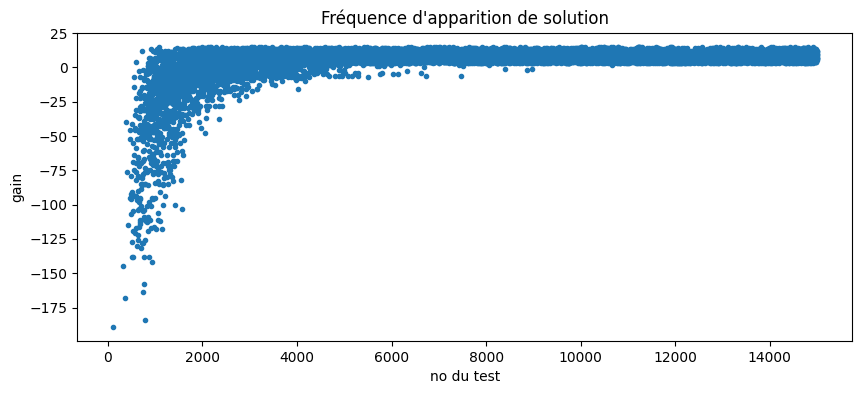

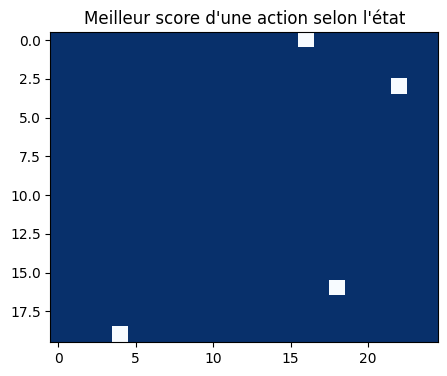

In [58]:
plot_frequence_sol(solutions)
showBestValues(Q)

## Algorithme Delayed Q-Learning


In [59]:
env = gym.make('Taxi-v3', render_mode='ansi') 
actions = { 0:'sud', 1:'nord', 2:'est', 3:'ouest', 4:'prendre un passager', 5: 'déposer un passager'}
lieux = {0:'R', 1:'G', 2:'Y', 3:'B'}

In [60]:
Q = np.zeros([env.observation_space.n,env.action_space.n])
lambda_learn = .2
gamma = 0.8
epsilon = 1.

In [61]:
def q_learn_delayed(nb_actions=64, m=20):
    """
    effectue un cycle d'apprentissage/recherche de solution' via le Q-Learning simple

    Parameters
    ----------
    epoch : no de l'etape

    Returns
    -------
    total_r : recompense totale
    r : recompense du dernier etat rencontre
    states_list : liste des etats traverses
    actions_list : liste des actions effectuees

    """
    s = env.reset()
    s = s[0]
    total_r = 0
    done = False
    step = 0
    states_list = []
    actions_list = []
    memory = []
    # The Q-Table learning algorithm
    while not done and step < nb_actions:
        step += 1
        # Choose an action by greedily (with noise) picking from Q table
        actions = Q[s, :]
        if rnd.random()<epsilon or np.max(actions)==0:
            a = rnd.randint(0, env.action_space.n-1)
        else:
            a = np.argmax(actions)

        # Get new state and reward from environment
        new_state, r, done,_, _ = env.step(a)
        memory.append((s, a, r, new_state))

        # to privilegiate the shortest path, get negative reward every step
        # if r == 0: r = -0.001

        # Q-Learning
        if step%m == 0:
            for s, a, r, new_state in memory:
                Q[s, a] = Q[s, a] + lambda_learn*(r + gamma * np.max(Q[new_state, :]) - Q[s, a])
                total_r = total_r + r
            memory.clear()

        s = new_state
        
        states_list.append(s)
        actions_list.append(a)
    return total_r, r, states_list, actions_list, done

In [62]:
def try_qlearn_delayed(nb_episodes = 4000, nb_actions = 64):
    """
    lance nb_episodes fois un cycle de Q-Learning et memorise chaque solution trouvee

    Returns
    -------
    solutions_list : liste des solutions (no, recompense totale, liste des etats, liste des actions)
    """
    global epsilon
    states_list = []
    actions_list = []
    solutions_list = []
    epsilon = 1
    for i in tqdm(range(nb_episodes)):
        # Reset environment and get first new observation
        total_r, r, states_list, actions_list, done = q_learn_delayed()
        epsilon = epsilon * 0.999
        # memorize if a solution has been found
        if done: solutions_list.append((i, total_r, states_list, actions_list))
        
    if(len(solutions_list) == 0): print("aucune solution trouvee !!")
    return solutions_list

In [63]:
##ON LANCE LA RESOLUTION : 
solutions = try_qlearn_delayed(15000, 50)
if(len(solutions)==0):print("pas de solution...")
#relancer le bloc si pas de solution trouvee

  0%|          | 0/15000 [00:00<?, ?it/s]

100%|██████████| 15000/15000 [00:06<00:00, 2370.86it/s]


In [64]:
##ON TESTE UNE RESOLUTION : 
if(len(solutions)>0):rendu(solutions)

une solution en  6  etapes : 
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+


+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)



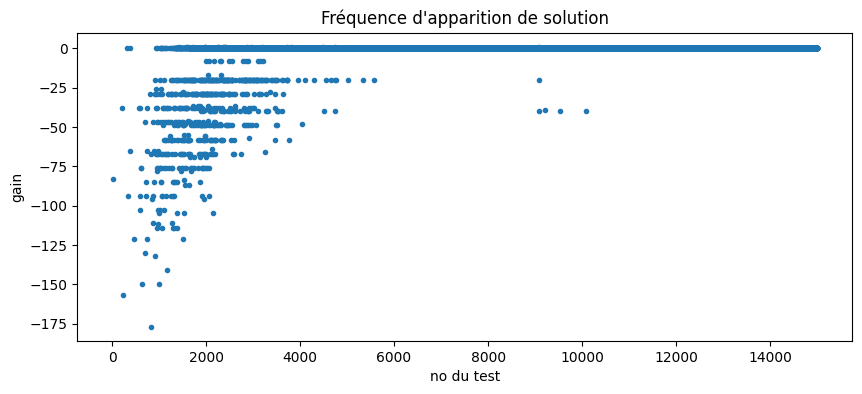

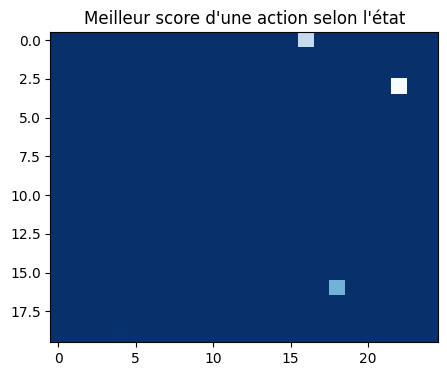

In [65]:
plot_frequence_sol(solutions)
showBestValues(Q)